In [1]:
using Random
using Statistics
using Distributions
using ShiftedArrays
using CategoricalArrays
# using StatsPlots
using HypothesisTests

using DataFrames
using DataFramesMeta
using SpecialFunctions
using LinearAlgebra
using StatsFuns
using MixedModels
using CodecZlib
using JLD2
using Serialization
using LaTeXStrings
using ShiftedArrays: lag
using Latexify
using Markdown

using Revise

using CairoMakie  
# CairoMakie.activate!(inline=true)
CairoMakie.activate!(type = "png", inline=true, px_per_unit=2.0, pt_per_unit=1.0)

In [13]:
using RLSR  # Needed for simulation
using EM
base_dir = ".."
results_dir = "$(base_dir)/results"
output_dir = "output"
include("$(base_dir)/code/em_scripts.jl")
include("$(base_dir)/code/sailing_base_mbsr_blockwise_betas_twotd.jl")
# include("$(base_dir)/code/switch_counts.jl")
include("$(base_dir)/code/regression_sim.jl")
;

In [8]:
function get_coefs(model, names)
    try
        name_subset = [n for n in names if n in unique(model.Name)]
        if length(name_subset) == 0
            return nothing
        end
        all_inds = [findfirst(model.Name .== name) for name in name_subset]
        coefs = model[all_inds, "Coef."]
        stderrs = model[all_inds, "Std. Error"]
        pvals = model[all_inds, "Pr(>|z|)"]
        return (coefs, stderrs, pvals, name_subset)
    catch
        return nothing
    end
end

get_coefs (generic function with 1 method)

In [3]:
set_theme!()
update_theme!(
        fontsize = 7,
        fonts = (; regular= "Helvetica", bold="Helvetica Bold"),
        # figure_padding = (10.0, 10.0, 10.0, 10.0),
        figure_padding = (5.0, 5.0, 5.0, 5.0),
        Lines = (
            linewidth = 1.0,
        )
    )


In [4]:
file_prefix = "blockwise"
full_df = load("../derived/$(file_prefix).jld2")["full_df"]
ntrials = maximum(full_df.trial)
full_df[1:5, :]

Row,state1,state2,state3,endState,endBranchLeft,reward,action1Left,action2Left,rewardₜ₋₁,rewardₜ₋₂,state1ₜ₋₁,state1ₜ₋₂,state1ₜ₋₃,state2ₜ₋₁,state2ₜ₋₂,state3ₜ₋₁,state3ₜ₋₂,endStateₜ₋₁,endStateₜ₋₂,endBranchLeftₜ₋₁,endBranchLeftₜ₋₂,trial,subject,action1TowardsPrevEnd,action1Persistance,endBranchₜ₋₁SameAsLastChoice,priorMoveAt1,priorMoveAt2,priorMoveAt3,parentPriorMove,parentPriorMoveToEndState,parentPriorMoveToEndStateₜ₋₁,priorRewardAt2,priorRewardAt3,priorRewardAt4,priorRewardAt5,priorRewardAt6,priorRewardAt7,endStateSiblingPriorReward,endStateSiblingPriorRewardₜ₋₁,endStatePriorReward,endStatePriorRewardₜ₋₁,endStatePriorRewardₜ₋₂,priorRewardLeftBranch,priorRewardRightBranch,endStateBranchPriorReward,endStateBranchPriorRewardₜ₋₁,endStateBranchPriorRewardₜ₋₂,sub,assignment,r1,r2,r3,r4,rt_boat,rt_island,rewscaled,rwd_swap,rwd_swap_type,block_ind,block_num
,Int64,Int64,Int64,Int64,Bool,Float64,Bool?,Bool?,Float64?,Float64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Bool?,Bool?,Int64,String,Bool?,Bool?,Bool?,Int64?,Int64?,Int64?,Int64?,Bool?,Bool?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64,String,Float64,Float64,Float64,Float64,Real,Union…,Float64,Bool,String,Int64,Int64
1,1,3,6,6,false,0.0,false,true,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,1,001,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,31.6,1743.3,-1.0,false,start,0,0
2,4,-1,-1,4,true,1.0,missing,missing,0.0,missing,1,missing,missing,3,missing,6,missing,6,missing,false,missing,2,001,missing,missing,missing,3,missing,6,missing,missing,missing,missing,missing,missing,missing,0.0,missing,missing,missing,missing,missing,missing,missing,0.0,missing,missing,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,3324.2,,1.0,false,start,1,0
3,1,2,4,4,true,1.0,true,true,1.0,0.0,4,1,missing,missing,3,missing,6,4,6,true,false,3,001,true,false,false,3,missing,6,missing,missing,missing,missing,missing,1.0,missing,0.0,missing,missing,missing,1.0,missing,missing,1.0,0.0,1.0,missing,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,1050.3,967,1.0,false,start,2,0
4,7,-1,-1,7,false,1.0,missing,missing,1.0,1.0,1,4,1,2,missing,4,missing,4,4,true,true,4,001,missing,missing,true,2,4,6,6,false,missing,missing,missing,1.0,missing,0.0,missing,0.0,missing,missing,1.0,missing,1.0,0.0,0.0,1.0,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,2148.6,,1.0,false,start,3,0
5,1,2,4,4,true,1.0,true,true,1.0,1.0,7,1,4,missing,2,missing,4,7,4,false,true,5,001,false,true,false,2,4,6,4,true,false,missing,missing,1.0,missing,0.0,1.0,missing,0.0,1.0,missing,1.0,1.0,1.0,1.0,0.0,1.0,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,841.6,1189.4,1.0,false,start,4,0


In [25]:
findall(.!ismissing.(full_df.rewardₜ₋₁) .& (full_df.rewardₜ₋₁ .== 1.0))

22840-element Vector{Int64}:
     3
     4
     5
     6
    11
    16
    17
    20
    21
    22
     ⋮
 39940
 39942
 39944
 39945
 39946
 39947
 39949
 39950
 39952

In [31]:
avgs_rwd = zeros(100)
avgs_norwd = zeros(100)
for s in 1:100
    x = full_df[findall((full_df.sub .== s) .& .!ismissing.(full_df.rewardₜ₋₁) .& .!ismissing.(full_df.action1TowardsPrevEnd) .& (full_df.rewardₜ₋₁ .== 1.0)), :action1TowardsPrevEnd]
    avgs_rwd[s] = mean(x)
    x = full_df[findall((full_df.sub .== s) .& .!ismissing.(full_df.rewardₜ₋₁) .& .!ismissing.(full_df.action1TowardsPrevEnd) .& (full_df.rewardₜ₋₁ .== 0.0)), :action1TowardsPrevEnd]
    avgs_norwd[s] = mean(x)
end

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/arik/.julia/packages/Makie/aG6xp/src/scenes.jl:227


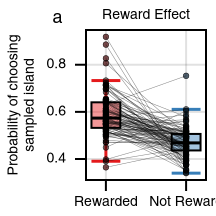

In [32]:
f = Figure(resolution=72 .* (1.5, 1.5))
colors = categorical_colors(:Set1, 4)
ax1 = Axis(f[1,1], xticks = (1:2, ["Rewarded", "Not Reward"]),
    ylabel="Probability of choosing\nsampled island",
    palette = (; patchcolor = colors),
    title = "Reward Effect",
)
Label(f[1, 1, TopLeft()], "a", fontsize = 9, font = :bold, padding = (0, 12, 2, 0), halign = :right)
boxplot!(repeat([1], inner=100), avgs_rwd,
        whiskerwidth = 1.0, whiskercolor = (colors[1], 1),
        strokecolor = :black, strokewidth = 1,
        color=(colors[1], 0.45),
        width=0.45,
        markersize=4,
)
boxplot!(repeat([2], inner=100), avgs_norwd,
        whiskerwidth = 1.0, whiskercolor = (colors[2], 1),
        strokecolor = :black, strokewidth = 1,
        color=(colors[2], 0.45),
        width=0.45,
        markersize=4,
)
for i in 1:100
    lines!([1, 2], [avgs_rwd[i], avgs_norwd[i]], color=(:black, 0.5), linewidth=0.25)
    scatter!([1, 2], [avgs_rwd[i], avgs_norwd[i]], color=(:black, 0.5), strokewidth=0.25, markersize=4)
end

# save("figures/reward_effect.pdf", f, pt_per_unit=1.0)
f

A few simulations to choose reasonable parameters for simulation

In [20]:
ver = "betas_twotd_BSR1_BBoat_a1_aM1_islandbias_boatbias_homeaway_rewscaled_initx-100"
RERUN = true
if RERUN
    extended = true  # Estimate SEs etc. on parameters
    threads = true
    rewscaled = true
    groups = nothing
    initx = true  # Simulate multiple starting points
    nstarts = 100
    decorrelateαβ = false
    full = false
    add_betas = false

    # Whether to fit the following as free parameters
    add_TDλ1 = false  # Assuming TD1, not fitting λ
    add_TDλ2 = false
    add_βTD_1 = false
    add_βTD_2 = false
    add_βMB1 = false
    add_βMB2 = false
    add_βSR1 = true
    add_βSR2 = false
    add_βBoat = true
    add_α1 = true
    add_α2 = false  # Split-Block Reward learning rate
    add_αM1 = true
    add_αM2 = false  # Split-Block SR learning rate
    add_initial_V = false  # Initial V as free paramter

    add_decay = false
    separate_decay = false
    add_island_stay_bias = true
    add_boat_stay_bias = true
    separate_home_away = true  # Separate learning rates for passive / traversal trials

    # Default values don't really matter here for anything being fit
    TDλ1 = nothing
    TDλ2 = nothing
    βTD_1 = nothing
    βTD_2 = nothing
    βMB1 = nothing
    βMB2 = nothing
    βSR1 = nothing
    βSR2 = nothing
    βBoat = nothing
    α1Home = nothing
    α1Away = nothing
    α2Home = nothing
    α2Away = nothing
    αM1 = nothing
    αM2 = nothing
    r_BSR1_homeaway = run_tdλ_mb_sr_blockwise_twotd(full_df; extended, threads, rewscaled, groups, initx, decorrelateαβ, full, add_betas,
        add_TDλ1, add_TDλ2, add_βTD_1, add_βTD_2, add_βMB1, add_βMB2, add_βSR1, add_βSR2, add_βBoat, add_α1, add_α2, add_αM1, add_αM2, add_initial_V,
        add_decay, separate_decay, add_island_stay_bias, add_boat_stay_bias, separate_home_away,
        TDλ1, TDλ2, βTD_1, βTD_2, βMB1, βMB2, βSR1, βSR2, βBoat, α1Home, α1Away, α2Home, α2Away, αM1, αM2,
        nstarts,
    )
    save("../results/modelfits/$(ver).jld2", "results", r_BSR1_homeaway)
end

varnames = ["βSR1", "βBoat", "island_stay_bias", "boat_stay_bias", "α1Home", "α1Away", "αM1"]
initbetas = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
initsigma = [5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0]
X = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

iter: 9
betas: [2.14 2.17 0.45 0.27 -0.71 0.35 -0.51]
sigma: [2.23, 1.8, 0.56, 0.27, 0.96, 0.52, 0.91]
free energy: -17189.551735
change: [2.9e-5, 0.0, 4.0e-6, 0.000168, -2.2e-5, 6.4e-5, -0.000215, 0.000103, 4.0e-6, 1.4e-5, 0.00069, 1.5e-5, 4.6e-5, 0.00034]
max: 0.00069


┌ Info: Running emerrors
└ @ Main /Users/arik/Library/CloudStorage/Dropbox/Princeton/SR_Paper/code/sailing_base_mbsr_blockwise_betas_twotd.jl:696


In [39]:
ver = "betas_twotd_BMB1_BBoat_a1_islandbias_boatbias_homeaway_rewscaled_initx-100"
RERUN = true
if RERUN
    extended = true  # Estimate SEs etc. on parameters
    threads = true
    rewscaled = true
    groups = nothing
    initx = true  # Simulate multiple starting points
    nstarts = 100
    decorrelateαβ = false
    full = false
    add_betas = false

    # Whether to fit the following as free parameters
    add_TDλ1 = false  # Assuming TD1, not fitting λ
    add_TDλ2 = false
    add_βTD_1 = false
    add_βTD_2 = false
    add_βMB1 = true
    add_βMB2 = false
    add_βSR1 = false
    add_βSR2 = false
    add_βBoat = true
    add_α1 = true
    add_α2 = false  # Split-Block Reward learning rate
    add_αM1 = false
    add_αM2 = false  # Split-Block SR learning rate
    add_initial_V = false  # Initial V as free paramter

    add_decay = false
    separate_decay = false
    add_island_stay_bias = true
    add_boat_stay_bias = true
    separate_home_away = true  # Separate learning rates for passive / traversal trials

    # Default values don't really matter here for anything being fit
    TDλ1 = nothing
    TDλ2 = nothing
    βTD_1 = nothing
    βTD_2 = nothing
    βMB1 = nothing
    βMB2 = nothing
    βSR1 = nothing
    βSR2 = nothing
    βBoat = nothing
    α1Home = nothing
    α1Away = nothing
    α2Home = nothing
    α2Away = nothing
    αM1 = nothing
    αM2 = nothing
    r_BMB1_homeaway = run_tdλ_mb_sr_blockwise_twotd(full_df; extended, threads, rewscaled, groups, initx, decorrelateαβ, full, add_betas,
        add_TDλ1, add_TDλ2, add_βTD_1, add_βTD_2, add_βMB1, add_βMB2, add_βSR1, add_βSR2, add_βBoat, add_α1, add_α2, add_αM1, add_αM2, add_initial_V,
        add_decay, separate_decay, add_island_stay_bias, add_boat_stay_bias, separate_home_away,
        TDλ1, TDλ2, βTD_1, βTD_2, βMB1, βMB2, βSR1, βSR2, βBoat, α1Home, α1Away, α2Home, α2Away, αM1, αM2,
        nstarts,
    )
    save("../results/modelfits/$(ver).jld2", "results", r_BMB1_homeaway)
end

varnames = ["βMB1", "βBoat", "island_stay_bias", "boat_stay_bias", "α1Home", "α1Away"]
initbetas = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
initsigma = [5.0, 5.0, 5.0, 5.0, 1.0, 1.0]
X = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

iter: 9
betas: [1.97 2.26 0.56 0.25 -0.72 0.21]
sigma: [1.8, 1.86, 0.67, 0.28, 0.91, 0.55]
free energy: -17126.633846
change: [9.2e-5, 4.4e-5, 3.6e-5, 6.3e-5, -7.0e-6, 3.1e-5, 0.000429, 0.000181, 3.5e-5, 0.000587, 6.3e-5, 0.000196]
max: 0.000587


┌ Info: Running emerrors
└ @ Main /Users/arik/Library/CloudStorage/Dropbox/Princeton/SR_Paper/code/sailing_base_mbsr_blockwise_betas_twotd.jl:696


In [35]:
ver = "betas_twotd_BMB1_BSR1_BBoat_a1_aM1_islandbias_boatbias_homeaway_rewscaled_initx-100"
RERUN = true
if RERUN
    extended = true  # Estimate SEs etc. on parameters
    threads = true
    rewscaled = true
    groups = nothing
    initx = true  # Simulate multiple starting points
    nstarts = 100
    decorrelateαβ = false
    full = false
    add_betas = false

    # Whether to fit the following as free parameters
    add_TDλ1 = false  # Assuming TD1, not fitting λ
    add_TDλ2 = false
    add_βTD_1 = false
    add_βTD_2 = false
    add_βMB1 = true
    add_βMB2 = false
    add_βSR1 = true
    add_βSR2 = false
    add_βBoat = true
    add_α1 = true
    add_α2 = false  # Split-Block Reward learning rate
    add_αM1 = true
    add_αM2 = false  # Split-Block SR learning rate
    add_initial_V = false  # Initial V as free paramter

    add_decay = false
    separate_decay = false
    add_island_stay_bias = true
    add_boat_stay_bias = true
    separate_home_away = true  # Separate learning rates for passive / traversal trials

    # Default values don't really matter here for anything being fit
    TDλ1 = nothing
    TDλ2 = nothing
    βTD_1 = nothing
    βTD_2 = nothing
    βMB1 = nothing
    βMB2 = nothing
    βSR1 = nothing
    βSR2 = nothing
    βBoat = nothing
    α1Home = nothing
    α1Away = nothing
    α2Home = nothing
    α2Away = nothing
    αM1 = nothing
    αM2 = nothing
    r_BMB1_BSR1_homeaway = run_tdλ_mb_sr_blockwise_twotd(full_df; extended, threads, rewscaled, groups, initx, decorrelateαβ, full, add_betas,
        add_TDλ1, add_TDλ2, add_βTD_1, add_βTD_2, add_βMB1, add_βMB2, add_βSR1, add_βSR2, add_βBoat, add_α1, add_α2, add_αM1, add_αM2, add_initial_V,
        add_decay, separate_decay, add_island_stay_bias, add_boat_stay_bias, separate_home_away,
        TDλ1, TDλ2, βTD_1, βTD_2, βMB1, βMB2, βSR1, βSR2, βBoat, α1Home, α1Away, α2Home, α2Away, αM1, αM2,
        nstarts,
    )
    save("../results/modelfits/$(ver).jld2", "results", r_BMB1_BSR1_homeaway)
end

varnames = ["βMB1", "βSR1", "βBoat", "island_stay_bias", "boat_stay_bias", "α1Home", "α1Away", "αM1"]
initbetas = [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
initsigma = [5.0, 5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0]
X = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

iter: 10
betas: [0.92 1.22 2.15 0.46 0.28 -0.67 0.32 -0.35]
sigma: [1.04, 1.18, 1.74, 0.59, 0.27, 0.97, 0.5, 0.9]
free energy: -17091.199905
change: [0.000621, 0.000542, 0.000125, 0.000374, 0.000302, -0.000198, 0.000297, -0.001097, 0.003982, 0.003268, 0.000468, 0.000176, 5.2e-5, 0.0001

┌ Info: Running emerrors
└ @ Main /Users/arik/Library/CloudStorage/Dropbox/Princeton/SR_Paper/code/sailing_base_mbsr_blockwise_betas_twotd.jl:696


In [51]:
function regression_sr_blockwise_cov_fixedalpha(centering, biastype, interactiontype, αHome, αAway; nsims=200, seed=nothing)
    suffix = "reg_sr_blockwise_cov_n-$(nsims)_aHome-$(αHome)_aAway-$(αAway)"
    if !isnothing(seed)
        Random.seed!(seed)
        suffix *= "_seed-$(seed)"
    end

    r = load("$(base_dir)/results/modelfits/betas_twotd_BSR1_BBoat_a1_aM1_islandbias_boatbias_homeaway_rewscaled_initx-100.jld2", "results")
    covm = sqrt(r.sigma)
    
    dfs = []
    for s in 1:nsims
        βTD0 = 0.0
        βTD1 = 0.0
        βSR = rand(Normal(r.betas[1], covm[1,1]))
        βMB = 0.0
        βBoat = rand(Normal(r.betas[2], covm[2,2]))
        island_bias = rand(Normal(r.betas[3], covm[3,3]))
        boat_bias = rand(Normal(r.betas[4], covm[4,4]))
        αM = unitnorm(rand(Normal(r.betas[7], covm[7,7])))
        γ = 1.0
        df = sim_blockwise_TD0TD1SRMB_subject(βTD0, βTD1, βSR, βMB, βBoat, island_bias, boat_bias, αHome, αAway, αM, γ, s)
        df[!, "sub"] .= s
        df[!, "subject"] .= lpad(s, 3, "0")
        push!(dfs, df)
    end
    df_reg = vcat(dfs...)

    add_all_regressors!(df_reg)
    df_reg = filter_df(df_reg)
    (extra_suffix, center_fn, fm) = make_reg_suffix(centering, biastype, interactiontype)
    suffix *= extra_suffix
    df_reg = center_fn(df_reg)
    @info suffix
    flush(stdout)

    result_reg = fit(MixedModel, fm, df_reg, Binomial(), progress=false)
    save("$(results_dir)/regression/$(suffix)_coeftable.jld2", "results", coeftable(result_reg); compress=true)
    result_reg
end
regression_sr_blockwise_cov_fixedalpha(:rwdchoice, :rwdonly, nothing, 0.5, 0.5; seed=0)
regression_sr_blockwise_cov_fixedalpha(:rwdchoice, :neighborboatlag5policylag5sameboatlag5, nothing, 0.5, 0.5; seed=0)
;

┌ Info: reg_sr_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_rwdonly
└ @ Main /Users/arik/Library/CloudStorage/Dropbox/Princeton/SR_Paper/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X52sZmlsZQ==.jl:34
┌ Info: reg_sr_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_neighborboatlag5policylag5sameboatlag5
└ @ Main /Users/arik/Library/CloudStorage/Dropbox/Princeton/SR_Paper/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X52sZmlsZQ==.jl:34


In [52]:
function regression_mb_blockwise_cov_fixedalpha(centering, biastype, interactiontype, αHome, αAway; nsims=200, seed=nothing)
    suffix = "reg_mb_blockwise_cov_n-$(nsims)_aHome-$(αHome)_aAway-$(αAway)"
    if !isnothing(seed)
        Random.seed!(seed)
        suffix *= "_seed-$(seed)"
    end

    r = load("$(base_dir)/results/modelfits/betas_twotd_BMB1_BBoat_a1_islandbias_boatbias_homeaway_rewscaled_initx-100.jld2", "results")
    covm = sqrt(r.sigma)
    
    dfs = []
    for s in 1:nsims
        βTD0 = 0.0
        βTD1 = 0.0
        βSR = 0.0
        βMB = rand(Normal(r.betas[1], covm[1,1]))
        βBoat = rand(Normal(r.betas[2], covm[2,2]))
        island_bias = rand(Normal(r.betas[3], covm[3,3]))
        boat_bias = rand(Normal(r.betas[4], covm[4,4]))
        αM = 0.0
        γ = 1.0
        df = sim_blockwise_TD0TD1SRMB_subject(βTD0, βTD1, βSR, βMB, βBoat, island_bias, boat_bias, αHome, αAway, αM, γ, s)
        df[!, "sub"] .= s
        df[!, "subject"] .= lpad(s, 3, "0")
        push!(dfs, df)
    end
    df_reg = vcat(dfs...)

    add_all_regressors!(df_reg)
    df_reg = filter_df(df_reg)
    (extra_suffix, center_fn, fm) = make_reg_suffix(centering, biastype, interactiontype)
    suffix *= extra_suffix
    df_reg = center_fn(df_reg)
    @info suffix
    flush(stdout)

    result_reg = fit(MixedModel, fm, df_reg, Binomial(), progress=false)
    save("$(results_dir)/regression/$(suffix)_coeftable.jld2", "results", coeftable(result_reg); compress=true)
    result_reg
end
regression_mb_blockwise_cov_fixedalpha(:rwdchoice, :rwdonly, nothing, 0.5, 0.5; seed=0)
regression_mb_blockwise_cov_fixedalpha(:rwdchoice, :neighborboatlag5policylag5sameboatlag5, nothing, 0.5, 0.5; seed=0)
;

┌ Info: reg_mb_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_rwdonly
└ @ Main /Users/arik/Library/CloudStorage/Dropbox/Princeton/SR_Paper/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X61sZmlsZQ==.jl:34
┌ Info: reg_mb_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_neighborboatlag5policylag5sameboatlag5
└ @ Main /Users/arik/Library/CloudStorage/Dropbox/Princeton/SR_Paper/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X61sZmlsZQ==.jl:34


In [57]:
function regression_mb_sr_blockwise_cov_fixedalpha(centering, biastype, interactiontype, αHome, αAway; nsims=200, seed=nothing)
    suffix = "reg_mb_sr_blockwise_cov_n-$(nsims)_aHome-$(αHome)_aAway-$(αAway)"
    if !isnothing(seed)
        Random.seed!(seed)
        suffix *= "_seed-$(seed)"
    end

    r = load("$(base_dir)/results/modelfits/betas_twotd_BMB1_BSR1_BBoat_a1_aM1_islandbias_boatbias_homeaway_rewscaled_initx-100.jld2", "results")
    covm = sqrt(r.sigma)
    
    dfs = []
    for s in 1:nsims
        βTD0 = 0.0
        βTD1 = 0.0
        βMB = rand(Normal(r.betas[1], covm[1,1]))
        βSR = rand(Normal(r.betas[2], covm[2,2]))
        βBoat = rand(Normal(r.betas[3], covm[3,3]))
        island_bias = rand(Normal(r.betas[4], covm[4,4]))
        boat_bias = rand(Normal(r.betas[5], covm[5,5]))
        αM = unitnorm(rand(Normal(r.betas[8], covm[8,8])))
        γ = 1.0
        df = sim_blockwise_TD0TD1SRMB_subject(βTD0, βTD1, βSR, βMB, βBoat, island_bias, boat_bias, αHome, αAway, αM, γ, s)
        df[!, "sub"] .= s
        df[!, "subject"] .= lpad(s, 3, "0")
        push!(dfs, df)
    end
    df_reg = vcat(dfs...)

    add_all_regressors!(df_reg)
    df_reg = filter_df(df_reg)
    (extra_suffix, center_fn, fm) = make_reg_suffix(centering, biastype, interactiontype)
    suffix *= extra_suffix
    df_reg = center_fn(df_reg)
    @info suffix
    flush(stdout)

    result_reg = fit(MixedModel, fm, df_reg, Binomial(), progress=false)
    save("$(results_dir)/regression/$(suffix)_coeftable.jld2", "results", coeftable(result_reg); compress=true)
    result_reg
end
regression_mb_sr_blockwise_cov_fixedalpha(:rwdchoice, :rwdonly, nothing, 0.5, 0.5)
regression_mb_sr_blockwise_cov_fixedalpha(:rwdchoice, :neighborboatlag5policylag5sameboatlag5, nothing, 0.5, 0.5)
;

┌ Info: reg_mb_sr_blockwise_cov_n-200_aHome-0.5_aAway-0.5_center-rwd-choice_rwdonly
└ @ Main /Users/arik/Library/CloudStorage/Dropbox/Princeton/SR_Paper/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X62sZmlsZQ==.jl:34
┌ Info: reg_mb_sr_blockwise_cov_n-200_aHome-0.5_aAway-0.5_center-rwd-choice_neighborboatlag5policylag5sameboatlag5
└ @ Main /Users/arik/Library/CloudStorage/Dropbox/Princeton/SR_Paper/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X62sZmlsZQ==.jl:34


In [61]:
function regression_participants(centering, biastype, interactiontype)
    suffix = "reg_participants"

    file_prefix = "blockwise"
    df_reg = load("$(base_dir)/derived/$(file_prefix).jld2")["full_df"]
    add_all_regressors!(df_reg)
    df_reg = filter_df(df_reg)
    (extra_suffix, center_fn, fm) = make_reg_suffix(centering, biastype, interactiontype)
    suffix *= extra_suffix
    df_reg = center_fn(df_reg)
    @info suffix
    flush(stdout)

    result_reg = fit(MixedModel, fm, df_reg, Binomial(), progress=false)
    save("$(results_dir)/regression/$(suffix)_coeftable.jld2", "results", coeftable(result_reg); compress=true)
    result_reg
end
regression_participants(:rwdchoice, :rwdonly, nothing)
regression_participants(:rwdchoice, :neighborboatlag5policylag5sameboatlag5, nothing)
;

┌ Info: reg_participants_center-rwd-choice_rwdonly
└ @ Main /Users/arik/Library/CloudStorage/Dropbox/Princeton/SR_Paper/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X50sZmlsZQ==.jl:11
┌ Info: reg_participants_center-rwd-choice_neighborboatlag5policylag5sameboatlag5
└ @ Main /Users/arik/Library/CloudStorage/Dropbox/Princeton/SR_Paper/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X50sZmlsZQ==.jl:11


# Regression Results

In [7]:
reg_rwdonly_sim_mb = DataFrame(load("$(base_dir)/results/regression/reg_mb_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_rwdonly_coeftable.jld2", "results"))
reg_rwdonly_sim_sr = DataFrame(load("$(base_dir)/results/regression/reg_sr_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_rwdonly_coeftable.jld2", "results"))
reg_rwdonly_sim_mb_sr = DataFrame(load("$(base_dir)/results/regression/reg_mb_sr_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_rwdonly_coeftable.jld2", "results"))
reg_rwdonly_participants = DataFrame(load("$(base_dir)/results/regression/reg_participants_center-rwd-choice_rwdonly_coeftable.jld2", "results"))
reg_full_sim_sr = DataFrame(load("$(base_dir)/results/regression/reg_sr_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_neighborboatlag5policylag5sameboatlag5_coeftable.jld2", "results"))
reg_full_sim_mb = DataFrame(load("$(base_dir)/results/regression/reg_mb_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_neighborboatlag5policylag5sameboatlag5_coeftable.jld2", "results"))
reg_full_sim_mb_sr = DataFrame(load("$(base_dir)/results/regression/reg_mb_sr_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_neighborboatlag5policylag5sameboatlag5_coeftable.jld2", "results"))
reg_full_participants = DataFrame(load("$(base_dir)/results/regression/reg_participants_center-rwd-choice_neighborboatlag5policylag5sameboatlag5_coeftable.jld2", "results"))
;

Full participant table

In [6]:
l = latexify(reg_full_participants; env = :table, booktabs = true, latex = false, fmt = x -> round(x, sigdigits=2))
using LaTeXStrings
show(latexstring(replace(l, "{ccccc}" => "{lrrrr}", "_" => "\\_", "rewardₜ₋₁" => "\$reward_{t-1}\$", "lag" => "\$lag", "reg" => "reg\$")))

L"\begin{tabular}{lrrrr}
\toprule
Name & Coef. & Std. Error & z & Pr(>|z|)\\
\midrule
(Intercept) & 0.21 & 0.052 & 4.0 & 5.9e-5\\
$reward_{t-1}$ & -0.00011 & 0.093 & -0.0012 & 1.0\\
$lag1\_neighborboat\_reg$ & -0.68 & 0.052 & -13.0 & 5.9e-39\\
$lag2\_neighborboat\_reg$ & -0.13 & 0.041 & -3.3 & 0.0011\\
$lag3\_neighborboat\_reg$ & -0.12 & 0.04 & -2.9 & 0.0039\\
$lag4\_neighborboat\_reg$ & -0.038 & 0.04 & -0.95 & 0.34\\
$lag5\_neighborboat\_reg$ & -0.12 & 0.04 & -2.9 & 0.0035\\
$lag1\_sameboat\_reg$ & 0.47 & 0.04 & 12.0 & 5.8e-32\\
$lag2\_sameboat\_reg$ & 0.17 & 0.04 & 4.2 & 2.7e-5\\
$lag3\_sameboat\_reg$ & 0.054 & 0.04 & 1.3 & 0.18\\
$lag4\_sameboat\_reg$ & 0.094 & 0.04 & 2.3 & 0.019\\
$lag5\_sameboat\_reg$ & 0.027 & 0.04 & 0.69 & 0.49\\
$lag1\_policy\_reg$ & -0.044 & 0.044 & -1.0 & 0.32\\
$lag2\_policy\_reg$ & -0.053 & 0.044 & -1.2 & 0.23\\
$lag3\_policy\_reg$ & 0.04 & 0.046 & 0.87 & 0.38\\
$lag4\_policy\_reg$ & 0.0027 & 0.046 & 0.06 & 0.95\\
$lag5\_policy\_reg$ & 0.051 & 0.044 & 1.2 &

Reward only participant table

In [64]:
l = latexify(reg_rwdonly_participants; env = :table, booktabs = true, latex = false, fmt = x -> round(x, sigdigits=2))
using LaTeXStrings
show(latexstring(replace(l, "{ccc}" => "{lrr}")))

L"$\begin{tabular}{ccccc}
\toprule
Name & Coef. & Std. Error & z & Pr(>|z|)\\
\midrule
(Intercept) & 0.13 & 0.022 & 6.1 & 1.2e-9\\
rewardₜ₋₁ & 0.5 & 0.052 & 9.7 & 4.600000000000001e-22\\
\bottomrule
\end{tabular}
$"

In [9]:
rwd_name = "rewardₜ₋₁"
mb_name = "rewardₜ₋₁ & lag1_neighborboat_reg"
sr_name = "rewardₜ₋₁ & lag1_policy_reg"
# mb_name = "rewardₜ₋₁ & endStateSiblingPriorNoRewardₜ₋₁"
# sr_name = "rewardₜ₋₁ & parentPriorMoveToEndStateₜ₋₁"
coefs_rwd_mb, stderrs_rwd_mb, pvals_rwd_mb, names_rwd_mb = get_coefs(reg_rwdonly_sim_mb, [rwd_name])
coefs_rwd_sr, stderrs_rwd_sr, pvals_rwd_sr, names_rwd_sr = get_coefs(reg_rwdonly_sim_sr, [rwd_name])
coefs_rwd_mb_sr, stderrs_rwd_mb_sr, pvals_rwd_mb_sr, names_rwd_mb_sr = get_coefs(reg_rwdonly_sim_mb_sr, [rwd_name])
coefs_rwd_participants, stderrs_rwd_participants, pvals_rwd_participants, names_rwd_participants = get_coefs(reg_rwdonly_participants, [rwd_name])
coefs_full_mb, stderrs_full_mb, pvals_full_mb, names_full_mb = get_coefs(reg_full_sim_mb, [rwd_name, mb_name, sr_name])
coefs_full_sr, stderrs_full_sr, pvals_full_sr, names_full_sr = get_coefs(reg_full_sim_sr, [rwd_name, mb_name, sr_name])
coefs_full_mb_sr, stderrs_full_mb_sr, pvals_full_mb_sr, names_full_mb_sr = get_coefs(reg_full_sim_mb_sr, [rwd_name, mb_name, sr_name])
coefs_full_participants, stderrs_full_participants, pvals_full_participants, names_full_participants = get_coefs(reg_full_participants, [rwd_name, mb_name, sr_name])
;

In [10]:
println("Rwd Only")
println("MB Estimate: ")
print("$(round(coefs_rwd_mb[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_rwd_mb[1]; sigdigits=3)), p < $(round(pvals_rwd_mb[1]; sigdigits=3))")
println("MB/SR")
println("$(round(coefs_rwd_mb_sr[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_rwd_mb_sr[1]; sigdigits=3)), p < $(round(pvals_rwd_mb_sr[1]; sigdigits=3))")
println("SR")
println("$(round(coefs_rwd_sr[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_rwd_sr[1]; sigdigits=3)), p < $(round(pvals_rwd_sr[1]; sigdigits=3))")
println("Participants")
println("$(round(coefs_rwd_participants[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_rwd_participants[1]; sigdigits=3)), p < $(round(pvals_rwd_participants[1]; sigdigits=3))")
println()
println("Full Model, Rwd")
println("MB")
println("$(round(coefs_full_mb[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_mb[1]; sigdigits=3)), p < $(round(pvals_full_mb[1]; sigdigits=3))")
println("MB/SR")
println("$(round(coefs_full_mb_sr[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_mb_sr[1]; sigdigits=3)), p < $(round(pvals_full_mb_sr[1]; sigdigits=3))")
println("SR")
println("$(round(coefs_full_sr[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_sr[1]; sigdigits=3)), p < $(round(pvals_full_sr[1]; sigdigits=3))")
println("Participants")
println("$(round(coefs_full_participants[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_participants[1]; sigdigits=3)), p < $(round(pvals_full_participants[1]; sigdigits=3))")
println()
println("Full Model, MB Effect")
println("MB")
println("$(round(coefs_full_mb[2]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_mb[2]; sigdigits=3)), p < $(round(pvals_full_mb[2]; sigdigits=3))")
println("MB/SR")
println("$(round(coefs_full_mb_sr[2]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_mb_sr[2]; sigdigits=3)), p < $(round(pvals_full_mb_sr[2]; sigdigits=3))")
println("SR")
println("$(round(coefs_full_sr[2]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_sr[2]; sigdigits=3)), p < $(round(pvals_full_sr[2]; sigdigits=3))")
println("Participants")
println("$(round(coefs_full_participants[2]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_participants[2]; sigdigits=3)), p < $(round(pvals_full_participants[2]; sigdigits=3))")
println()
println("Full Model, SR Effect")
println("MB")
println("$(round(coefs_full_mb[3]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_mb[3]; sigdigits=3)), p < $(round(pvals_full_mb[3]; sigdigits=3))")
println("MB/SR")
println("$(round(coefs_full_mb_sr[3]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_mb_sr[3]; sigdigits=3)), p < $(round(pvals_full_mb_sr[3]; sigdigits=3))")
println("SR")
println("$(round(coefs_full_sr[3]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_sr[3]; sigdigits=3)), p < $(round(pvals_full_sr[3]; sigdigits=3))")
println("Participants")
println("$(round(coefs_full_participants[3]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_participants[3]; sigdigits=3)), p < $(round(pvals_full_participants[3]; sigdigits=3))")

Rwd Only
MB Estimate: 
0.433, 95\% CI = +/- 0.0519, p < 4.52e-60MB/SR
0.434, 95\% CI = +/- 0.0509, p < 1.24e-62
SR
0.4, 95\% CI = +/- 0.0495, p < 1.1900000000000001e-56
Participants
0.5, 95\% CI = +/- 0.101, p < 4.59e-22

Full Model, Rwd
MB
-0.43, 95\% CI = +/- 0.11, p < 1.64e-14
MB/SR
-0.177, 95\% CI = +/- 0.125, p < 0.00541
SR
0.131, 95\% CI = +/- 0.13, p < 0.0487
Participants
-0.000115, 95\% CI = +/- 0.182, p < 0.999

Full Model, MB Effect
MB
0.794, 95\% CI = +/- 0.127, p < 2.3199999999999997e-34
MB/SR
0.347, 95\% CI = +/- 0.125, p < 6.01e-8
SR
-0.0883, 95\% CI = +/- 0.109, p < 0.111
Participants
0.74, 95\% CI = +/- 0.215, p < 1.51e-11

Full Model, SR Effect
MB
-0.00813, 95\% CI = +/- 0.131, p < 0.903
MB/SR
0.538, 95\% CI = +/- 0.16, p < 4.81e-11
SR
0.697, 95\% CI = +/- 0.157, p < 3.02e-18
Participants
0.382, 95\% CI = +/- 0.178, p < 2.59e-5


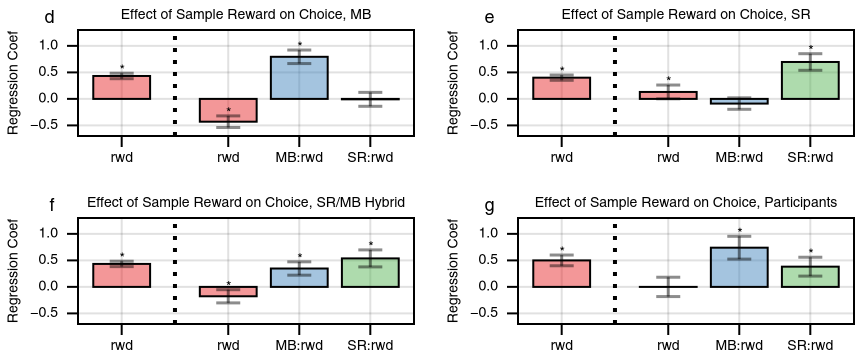

In [12]:
f = Figure(size=72 .* (6.0, 2.5))
colors = categorical_colors(:Set1, 4)

coefs_rwd = coefs_rwd_mb
stderrs_rwd = stderrs_rwd_mb
pvals_rwd = pvals_rwd_mb
coefs_full = coefs_full_mb
stderrs_full = stderrs_full_mb
pvals_full = pvals_full_mb
ax = Axis(f[1,1], xticks = ([1,2.5,3.5,4.5], ["rwd", "rwd", "MB:rwd", "SR:rwd"]),
    ylabel="Regression Coef",
    palette = (; patchcolor = colors),
    title = "Effect of Sample Reward on Choice, MB",
)
Label(f[1, 1, TopLeft()], "d", fontsize = 9, font = :bold, padding = (0, 12, 2, 0), halign = :right)
ylims!(-0.7, 1.3)
barplot!([1], coefs_rwd, strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
errorbars!([1], coefs_rwd, 1.96 .* stderrs_rwd, whiskerwidth = 12.0, color=(:black, 0.45))
barplot!([2.5], [coefs_full[1]], strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
barplot!([3.5], [coefs_full[2]], strokecolor = :black, strokewidth = 1, color=(colors[2], 0.45))
barplot!([4.5], [coefs_full[3]], strokecolor = :black, strokewidth = 1, color=(colors[3], 0.45))
errorbars!([2.5, 3.5, 4.5], coefs_full, 1.96 .* stderrs_full, whiskerwidth = 12.0, color=(:black, 0.45))
vlines!(ax, [1.75], color=:black, linewidth=2, linestyle=:dot)
if pvals_rwd[1] < 0.05
    text!(1-0.03, (coefs_rwd .+ 1.96 .* stderrs_rwd)[1] - 0.08; text="*")
end
for i in 1:3
    if pvals_full[i] < 0.05
        text!(i + 1.5 - 0.03, (coefs_full .+ 1.96 .* stderrs_full)[i] - 0.08; text="*")
    end
end

coefs_rwd = coefs_rwd_sr
stderrs_rwd = stderrs_rwd_sr
pvals_rwd = pvals_rwd_sr
coefs_full = coefs_full_sr
stderrs_full = stderrs_full_sr
pvals_full = pvals_full_sr
ax = Axis(f[1,2], xticks = ([1,2.5,3.5,4.5], ["rwd", "rwd", "MB:rwd", "SR:rwd"]),
    ylabel="Regression Coef",
    palette = (; patchcolor = colors),
    title = "Effect of Sample Reward on Choice, SR",
)
Label(f[1, 2, TopLeft()], "e", fontsize = 9, font = :bold, padding = (0, 12, 2, 0), halign = :right)
ylims!(-0.7, 1.3)
barplot!([1], coefs_rwd, strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
errorbars!([1], coefs_rwd, 1.96 .* stderrs_rwd, whiskerwidth = 12.0, color=(:black, 0.45))
barplot!([2.5], [coefs_full[1]], strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
barplot!([3.5], [coefs_full[2]], strokecolor = :black, strokewidth = 1, color=(colors[2], 0.45))
barplot!([4.5], [coefs_full[3]], strokecolor = :black, strokewidth = 1, color=(colors[3], 0.45))
errorbars!([2.5, 3.5, 4.5], coefs_full, 1.96 .* stderrs_full, whiskerwidth = 12.0, color=(:black, 0.45))
vlines!(ax, [1.75], color=:black, linewidth=2, linestyle=:dot)
if pvals_rwd[1] < 0.05
    text!(1-0.03, (coefs_rwd .+ 1.96 .* stderrs_rwd)[1] - 0.08; text="*")
end
for i in 1:3
    if pvals_full[i] < 0.05
        text!(i + 1.5 - 0.03, (coefs_full .+ 1.96 .* stderrs_full)[i] - 0.08; text="*")
    end
end

coefs_rwd = coefs_rwd_mb_sr
stderrs_rwd = stderrs_rwd_mb_sr
pvals_rwd = pvals_rwd_mb_sr
coefs_full = coefs_full_mb_sr
stderrs_full = stderrs_full_mb_sr
pvals_full = pvals_full_mb_sr
ax = Axis(f[2,1], xticks = ([1,2.5,3.5,4.5], ["rwd", "rwd", "MB:rwd", "SR:rwd"]),
    ylabel="Regression Coef",
    palette = (; patchcolor = colors),
    title = "Effect of Sample Reward on Choice, SR/MB Hybrid",
)
Label(f[2, 1, TopLeft()], "f", fontsize = 9, font = :bold, padding = (0, 12, 2, 0), halign = :right)
ylims!(-0.7, 1.3)
barplot!([1], coefs_rwd, strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
errorbars!([1], coefs_rwd, 1.96 .* stderrs_rwd, whiskerwidth = 12.0, color=(:black, 0.45))
barplot!([2.5], [coefs_full[1]], strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
barplot!([3.5], [coefs_full[2]], strokecolor = :black, strokewidth = 1, color=(colors[2], 0.45))
barplot!([4.5], [coefs_full[3]], strokecolor = :black, strokewidth = 1, color=(colors[3], 0.45))
errorbars!([2.5, 3.5, 4.5], coefs_full, 1.96 .* stderrs_full, whiskerwidth = 12.0, color=(:black, 0.45))
vlines!(ax, [1.75], color=:black, linewidth=2, linestyle=:dot)
if pvals_rwd[1] < 0.05
    text!(1-0.03, (coefs_rwd .+ 1.96 .* stderrs_rwd)[1] - 0.08; text="*")
end
for i in 1:3
    if pvals_full[i] < 0.05
        text!(i + 1.5 - 0.03, (coefs_full .+ 1.96 .* stderrs_full)[i] - 0.08; text="*")
    end
end

coefs_rwd = coefs_rwd_participants
stderrs_rwd = stderrs_rwd_participants
pvals_rwd = pvals_rwd_participants
coefs_full = coefs_full_participants
stderrs_full = stderrs_full_participants
pvals_full = pvals_full_participants
ax = Axis(f[2,2], xticks = ([1,2.5,3.5,4.5], ["rwd", "rwd", "MB:rwd", "SR:rwd"]),
    ylabel="Regression Coef",
    palette = (; patchcolor = colors),
    title = "Effect of Sample Reward on Choice, Participants",
)
Label(f[2, 2, TopLeft()], "g", fontsize = 9, font = :bold, padding = (0, 12, 2, 0), halign = :right)
ylims!(-0.7, 1.3)
barplot!([1], coefs_rwd, strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
errorbars!([1], coefs_rwd, 1.96 .* stderrs_rwd, whiskerwidth = 12.0, color=(:black, 0.45))
barplot!([2.5], [coefs_full[1]], strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
barplot!([3.5], [coefs_full[2]], strokecolor = :black, strokewidth = 1, color=(colors[2], 0.45))
barplot!([4.5], [coefs_full[3]], strokecolor = :black, strokewidth = 1, color=(colors[3], 0.45))
errorbars!([2.5, 3.5, 4.5], coefs_full, 1.96 .* stderrs_full, whiskerwidth = 12.0, color=(:black, 0.45))
vlines!(ax, [1.75], color=:black, linewidth=2, linestyle=:dot)
if pvals_rwd[1] < 0.05
    text!(1-0.03, (coefs_rwd .+ 1.96 .* stderrs_rwd)[1] - 0.08; text="*")
end
for i in 1:3
    if pvals_full[i] < 0.05
        text!(i + 1.5 - 0.03, (coefs_full .+ 1.96 .* stderrs_full)[i] - 0.08; text="*")
    end
end


save("figures/model_coefs.pdf", f, pt_per_unit=1)
f